In [13]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import emoji
import torch
import json
import time

from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
# getting the twitter comments
DATA_PATH = '../data/twitter-data-cleaned.txt'
with open(DATA_PATH, 'r',  encoding="utf-8") as f:
    data = f.readlines()
data = [d.strip() for d in data if d.strip() != '']
print('Tweets')
print(data[:3])
print(len(data))

# getting our chosen emojis
SELECTED_EMOJIS_PATH = '../data/best-emojis.json'
with open(SELECTED_EMOJIS_PATH, 'r') as f:
    EMOJIS = json.load(f)
EMOJI_CHARS = [e['char'] for e in EMOJIS]
print('Chosen emojis')
print(EMOJI_CHARS)
print(len(EMOJI_CHARS))

ALL_EMOJIS = set(emoji.emojize(emoji_code) for emoji_code in emoji.UNICODE_EMOJI.values())

Tweets
['💫 IT’S BURGER MONDAY, CBUS! 💫 Order any Gourmet Burger with a draft beer 🍔🍺 ifor just $9.99 when you dine in. 💪 Cer…', 'Stay strong 💪 You are an amazing man. I appreciate the truth that is told.', 'Code Sale Awesome from Styli 💪']
122179
Chosen emojis
['😂', '😍', '😭', '😊', '💕', '😒', '😉', '👌', '👍', '🙏', '👀', '🔥', '💯', '👏', '💪']
15


In [4]:
# preprocessing the data
from parsing import Tokenizer, TokenType, Token
tokenizer = Tokenizer(EMOJI_CHARS)
# take 3 previous words as context for the emoji
context = {e:[] for e in EMOJI_CHARS}
emojiToId = {e:i for i,e in enumerate(EMOJI_CHARS)}

for tweet in data:
    tokens = tokenizer.tokenize(tweet)
    for i,token in enumerate(tokens):
        if token.token_type == TokenType.EMOJIS:
            closest = tokenizer.findClosestNWords(5, tokens, i)
            if closest:
                context[token.raw].append(closest)

for e, words in context.items():
    print(e)
    print(len(words))
    print(words[:3])

😂
8458
[['familiar', 'with', 'my', 'face', 'too'], ['bollywood', 'reality'], ['though', 'your', 'debates', 'be', 'blasphemy']]
😍
7330
[['figura', 'is', 'a', 'start', 'today'], ['200', 'days', 'to', 'go'], ['200', 'days', 'to', 'go']]
😭
7464
[['lol', 'procrastination', 'almost', 'had', 'me'], ['just', 'change', 'my', 'first', 'diaper'], ['52', 'yuan', 'for', 'this', 'set']]
😊
6352
[['you', 'today', 'credit', 'stacie', 'swift'], ['fantastic', 'well', 'done', 'ladies'], ['congratulations', 'fam', 'all', 'the', 'best']]
💕
6485
[['happy', 'birthday', 'my', 'mochiiii', 'saranghae'], ['got', 'this', 'soon', 'youre', 'done'], ['we', 'got', 'this']]
😒
5873
[['️', 'dunk', 'it', 'ang', 'hina'], ['comes', '17', 'on', 'uber', 'eats'], ['comes', '17', 'on', 'uber', 'eats']]
😉
5932
[['start', 'today', 'choose', 'your', 'package'], ['the', 'richest', 'man', 'your', 'age'], ['yall', 'know', 'the', 'rest']]
👌
6035
[['yess'], ['nice', 'one', 'you', 'are', 'a'], ['the', 'best', 'and', 'great', 'artist']]


In [5]:
# making X and y for TFIDF as a baseline idea of how good our accuracy can expect to be
X_words = []
y = []
sentences = set()
for e, words in context.items():
    for i,word_list in enumerate(words):
        sentence = ' '.join(word_list)
        if sentence in sentences:
            continue
        sentences.add(sentence)
        X_words.append(sentence)
        y.append(emojiToId[e])
print(len(y))

75537


In [8]:
# attempting to use tfidf and RF
# WARNING: can take a decent amount of time: 5 mins or so?
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_words)

model = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(model, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.20 (+/- 0.01)


In [14]:
# attempting to use count_vectorizer and RF
# WARNING: can take a decent amount of time: 5 mins or so?
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_words)
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

model = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(model, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [15]:
# making X and y for RNN
X_words = []
y = []
sentences = set()
for e, words in context.items():
    for i, sentence in enumerate(words):
        check = ' '.join(sentence)
        if check in sentences:
            continue
        sentences.add(check)
        X_words.append(sentence)
        y.append(emojiToId[e])
print(X_words[0])
print(len(y))

['familiar', 'with', 'my', 'face', 'too']
75537


In [16]:
# making word embeddings for RNN
UNK = "<unk>"
WORDEMBSIZE = 32
W2V_WINDOW = 7
W2V_COUNT = 1
W2V_EPOCH=100

def makeVocab(text):
    vocab = set()
    for sentences in text:
        for word in sentences:
            vocab.add(word)
    return vocab

def makeEmbModel(data):
    docs = [[UNK]]
    docs.extend(data)
    model = Word2Vec(window=W2V_WINDOW, min_count=W2V_COUNT, size=WORDEMBSIZE)
    model.build_vocab(docs)
    model.train(docs, total_examples=len(docs), epochs=W2V_EPOCH)
    print(model)
    return model

def makeEmbeddings(data, model, vocab):
    vecData = []
    for sentence in data:
        wordEmbs = []
        for word in sentence:
            if word in vocab:
#                 print(type(model[word]))
#                 print(model[word])
                wordEmbs.append(model[word])
            else:
                wordEmbs.append(np.zeros(WORDEMBSIZE))
        wordEmbs = torch.FloatTensor(wordEmbs)
        vecData.append(wordEmbs)
    return vecData

In [18]:
# continue making word embeddings
X_words_train, X_words_test, y_train, y_test = train_test_split(X_words, y, train_size=0.8, test_size=0.2, random_state=42)
vocab = makeVocab(X_words_train)
emb_model = makeEmbModel(X_words_train)
vocab = set(list(emb_model.wv.vocab.keys()))
X_train = makeEmbeddings(X_words_train, emb_model, vocab)
X_test = makeEmbeddings(X_words_test, emb_model, vocab)

print(X_words_train[0])
print(X_train[0])
print(y_train[0])

Word2Vec(vocab=28504, size=64, alpha=0.025)


/Users/ericsun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


['in', 'such', 'a', 'distinguished', 'list']
tensor([[-1.7283e+00, -4.0847e-01,  1.0551e+00,  3.9535e-01,  2.3846e-01,
         -4.8657e-01,  2.7928e-01, -2.3061e+00, -3.0334e+00, -6.1305e-01,
         -1.9482e+00, -8.4794e-01,  9.2922e-01,  1.0158e+00,  6.7960e-01,
          1.0427e+00,  1.6248e+00,  1.7842e-01,  1.8113e+00,  2.0307e+00,
          2.8751e-01, -7.8694e-01,  1.7978e+00, -1.2655e+00,  2.3116e-01,
         -1.7247e+00,  1.8191e+00, -7.4418e-01, -2.4973e-01,  1.4937e-01,
          9.1150e-01, -1.5408e+00, -1.6699e+00, -6.7079e-01,  2.5512e-02,
         -1.3191e+00,  2.2699e-01,  8.3313e-02,  2.5308e+00,  3.5827e-01,
          2.9905e-02,  3.5009e-01,  7.1662e-01,  1.3336e+00,  1.3198e+00,
          6.2618e-01,  6.8009e-01,  9.7643e-01, -3.7402e-02,  2.9115e-01,
          6.3057e-02, -2.0480e+00,  2.2243e+00,  4.7334e-01,  1.1688e+00,
          7.0880e-01, -7.7619e-01, -2.7164e-01, -2.9492e-01, -8.8393e-01,
         -1.1925e+00, -1.5357e+00, -1.5316e+00,  5.8354e-01],
     

In [19]:
# RNN building to predict result
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [20]:
# RNN model
class RNN(nn.Module):
    def __init__(self, input_dim, h, output_dim = 15):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, h, dropout=0.2)
        self.finalLayer = nn.Linear(h, output_dim)
        self.input_dim = input_dim
        self.hidden_dim = h
        self.output_dim =  output_dim
#         self.word_embeddings = nn.Embedding(vocab_size, input_dim)
        self.softmax = nn.LogSoftmax()
        self.loss = nn.NLLLoss()
    
    def compute_loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)
    
    def forward(self, inputs):
        out, hidden = self.rnn(inputs)
        hidden = hidden.contiguous().view(-1,self.hidden_dim)
        predicted_vector = self.softmax(self.finalLayer(hidden))
        return predicted_vector



-------------
EPOCH: 1
Training started for epoch:1


/Users/ericsun/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


/Users/ericsun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Training completed for epoch: 1
Time for train: 95.93112516403198
Accuracy: 0.14896716101694915
Validation started for epoch:1



Validation completed for epoch: 1
Time for validation: 10.063143253326416
Accuracy: 0.17478813559322035


-------------
EPOCH: 2
Training started for epoch:2



Training completed for epoch: 2
Time for train: 91.85907673835754
Accuracy: 0.18359375
Validation started for epoch:2



Validation completed for epoch: 2
Time for validation: 11.174176931381226
Accuracy: 0.1841896186440678


-------------
EPOCH: 3
Training started for epoch:3



Training completed for epoch: 3
Time for train: 89.48292803764343
Accuracy: 0.1917372881355932
Validation started for epoch:3



Validation completed for epoch: 3
Time for validation: 10.802212238311768
Accuracy: 0.18730137711864406


-------------
EPOCH: 4
Training started for epoch:4



Training completed for epoch: 4
Time for train: 96.02989077568054
Accuracy: 0.19618975105932204
Validation started for epoch:4



Validation completed for epoch: 4
Time for validation: 10.16031002998352
Accuracy: 0.1876324152542373


-------------
EPOCH: 5
Training started for epoch:5



Training completed for epoch: 5
Time for train: 91.27945518493652
Accuracy: 0.2013870497881356
Validation started for epoch:5



Validation completed for epoch: 5
Time for validation: 10.115947008132935
Accuracy: 0.19299523305084745


-------------
EPOCH: 6
Training started for epoch:6



Training completed for epoch: 6
Time for train: 91.73944592475891
Accuracy: 0.20742849576271186
Validation started for epoch:6



Validation completed for epoch: 6
Time for validation: 28.765470266342163
Accuracy: 0.19001588983050846


-------------
EPOCH: 7
Training started for epoch:7



Training completed for epoch: 7
Time for train: 97.8590190410614
Accuracy: 0.21007680084745764
Validation started for epoch:7



Validation completed for epoch: 7
Time for validation: 18.662205934524536
Accuracy: 0.1937897245762712


-------------
EPOCH: 8
Training started for epoch:8



Training completed for epoch: 8
Time for train: 95.65928411483765
Accuracy: 0.2131885593220339
Validation started for epoch:8



Validation completed for epoch: 8
Time for validation: 10.066689014434814
Accuracy: 0.1951800847457627


-------------
EPOCH: 9
Training started for epoch:9



Training completed for epoch: 9
Time for train: 109.23164486885071
Accuracy: 0.21800516419491525
Validation started for epoch:9



Validation completed for epoch: 9
Time for validation: 13.88037109375
Accuracy: 0.1939883474576271


-------------
EPOCH: 10
Training started for epoch:10



Training completed for epoch: 10
Time for train: 88.83085298538208
Accuracy: 0.22028932733050846
Validation started for epoch:10



Validation completed for epoch: 10
Time for validation: 9.643594026565552
Accuracy: 0.1918697033898305


-------------
EPOCH: 11
Training started for epoch:11



Training completed for epoch: 11
Time for train: 88.09929418563843
Accuracy: 0.22343418961864406
Validation started for epoch:11



Validation completed for epoch: 11
Time for validation: 9.595454216003418
Accuracy: 0.1960407838983051


-------------
EPOCH: 12
Training started for epoch:12



Training completed for epoch: 12
Time for train: 88.22367811203003
Accuracy: 0.2278038930084746
Validation started for epoch:12



Validation completed for epoch: 12
Time for validation: 9.877168893814087
Accuracy: 0.192333156779661


-------------
EPOCH: 13
Training started for epoch:13



Training completed for epoch: 13
Time for train: 90.72325491905212
Accuracy: 0.2299556408898305
Validation started for epoch:13



Validation completed for epoch: 13
Time for validation: 10.000356912612915
Accuracy: 0.19690148305084745


-------------
EPOCH: 14
Training started for epoch:14



Training completed for epoch: 14
Time for train: 111.60158514976501
Accuracy: 0.23397775423728814
Validation started for epoch:14



Validation completed for epoch: 14
Time for validation: 11.04136610031128
Accuracy: 0.1972987288135593


-------------
EPOCH: 15
Training started for epoch:15



Training completed for epoch: 15
Time for train: 94.6759729385376
Accuracy: 0.23889367055084745
Validation started for epoch:15



Validation completed for epoch: 15
Time for validation: 10.288959980010986
Accuracy: 0.196239406779661


-------------
EPOCH: 16
Training started for epoch:16



Training completed for epoch: 16
Time for train: 90.84682106971741
Accuracy: 0.2421543961864407
Validation started for epoch:16



Validation completed for epoch: 16
Time for validation: 10.57941222190857
Accuracy: 0.1994835805084746


-------------
EPOCH: 17
Training started for epoch:17



Training completed for epoch: 17
Time for train: 101.02442693710327
Accuracy: 0.24649099576271186
Validation started for epoch:17



Validation completed for epoch: 17
Time for validation: 9.770579099655151
Accuracy: 0.1933262711864407


-------------
EPOCH: 18
Training started for epoch:18



Training completed for epoch: 18
Time for train: 89.76984882354736
Accuracy: 0.24822894597457626
Validation started for epoch:18



Validation completed for epoch: 18
Time for validation: 9.632574796676636
Accuracy: 0.19551112288135594


-------------
EPOCH: 19
Training started for epoch:19



Training completed for epoch: 19
Time for train: 92.02487182617188
Accuracy: 0.252052436440678
Validation started for epoch:19



Validation completed for epoch: 19
Time for validation: 9.689014911651611
Accuracy: 0.194385593220339


-------------
EPOCH: 20
Training started for epoch:20



Training completed for epoch: 20
Time for train: 100.64957284927368
Accuracy: 0.2552635063559322
Validation started for epoch:20



Validation completed for epoch: 20
Time for validation: 11.442238092422485
Accuracy: 0.19676906779661016


-------------
EPOCH: 21
Training started for epoch:21



Training completed for epoch: 21
Time for train: 105.50145292282104
Accuracy: 0.2573821504237288
Validation started for epoch:21



Validation completed for epoch: 21
Time for validation: 11.28217887878418
Accuracy: 0.1945842161016949


-------------
EPOCH: 22
Training started for epoch:22



Training completed for epoch: 22
Time for train: 91.81104278564453
Accuracy: 0.2603283898305085
Validation started for epoch:22



Validation completed for epoch: 22
Time for validation: 12.954815149307251
Accuracy: 0.19643802966101695


-------------
EPOCH: 23
Training started for epoch:23



Training completed for epoch: 23
Time for train: 148.53427028656006
Accuracy: 0.2639863612288136
Validation started for epoch:23



Validation completed for epoch: 23
Time for validation: 42.966962814331055
Accuracy: 0.1990863347457627


-------------
EPOCH: 24
Training started for epoch:24



Training completed for epoch: 24
Time for train: 215.50362968444824
Accuracy: 0.2671643273305085
Validation started for epoch:24



Validation completed for epoch: 24
Time for validation: 10.087035894393921
Accuracy: 0.19061175847457626


-------------
EPOCH: 25
Training started for epoch:25



Training completed for epoch: 25
Time for train: 89.40113997459412
Accuracy: 0.2713354078389831
Validation started for epoch:25



Validation completed for epoch: 25
Time for validation: 9.681769132614136
Accuracy: 0.19226694915254236


-------------
EPOCH: 26
Training started for epoch:26



Training completed for epoch: 26
Time for train: 93.93307995796204
Accuracy: 0.2753244173728814
Validation started for epoch:26



Validation completed for epoch: 26
Time for validation: 10.766692161560059
Accuracy: 0.18802966101694915


-------------
EPOCH: 27
Training started for epoch:27



Training completed for epoch: 27
Time for train: 89.68461608886719
Accuracy: 0.2788334216101695
Validation started for epoch:27



Validation completed for epoch: 27
Time for validation: 12.116496801376343
Accuracy: 0.18981726694915255


-------------
EPOCH: 28
Training started for epoch:28



Training completed for epoch: 28
Time for train: 91.66417193412781
Accuracy: 0.2806044756355932
Validation started for epoch:28



Validation completed for epoch: 28
Time for validation: 9.925866842269897
Accuracy: 0.1880958686440678


-------------
EPOCH: 29
Training started for epoch:29



Training completed for epoch: 29
Time for train: 115.79609179496765
Accuracy: 0.2841465836864407
Validation started for epoch:29



Validation completed for epoch: 29
Time for validation: 9.738513231277466
Accuracy: 0.18650688559322035


-------------
EPOCH: 30
Training started for epoch:30



Training completed for epoch: 30
Time for train: 92.70784187316895
Accuracy: 0.2883176641949153
Validation started for epoch:30



Validation completed for epoch: 30
Time for validation: 9.941138982772827
Accuracy: 0.1873675847457627


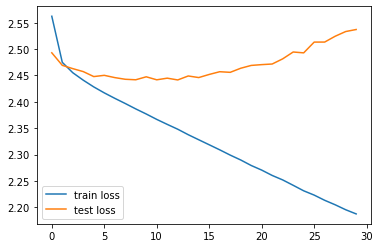

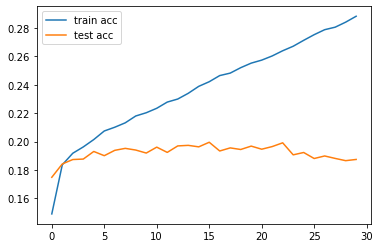

In [21]:
# running epochs for training and validation
HIDDEN_DIM = 128
EPOCHS = 30
minibatch_size = 16

model = RNN(WORDEMBSIZE, HIDDEN_DIM, 15)
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(EPOCHS):
    print("\n\n-------------")
    print("EPOCH: {}".format(epoch + 1))
    running_loss = 0.0
    model.train()
    optimizer.zero_grad()
    print("Training started for epoch: {}".format(epoch + 1))
    X_train, y_train = shuffle(X_train, y_train)
    start_time = time.time()
    correct = total = 0
    N = len(y_train)
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for idx in range(minibatch_size):
            text = X_train[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            labelIdx = y_train[minibatch_idx * minibatch_size + idx]
            log_probs = model(text)
            text_loss = model.compute_loss(log_probs.view(1,-1), torch.tensor([labelIdx]))
            running_loss += text_loss
            if loss is None:
                loss = text_loss
            else:
                loss += text_loss
            pred_label = torch.argmax(log_probs)
            correct += int(pred_label == labelIdx)
            total += 1
        loss = loss / minibatch_size
        loss.backward()
        optimizer.step()
    train_loss.append(running_loss / N)
    train_acc.append(correct / total)
    print("Training completed for epoch: {}".format(epoch + 1))
    print("Time for train: {}".format(time.time() - start_time))
    print("Accuracy: {}".format(correct / total))
    
    #validation
    running_loss = 0.0
    model.eval()
    optimizer.zero_grad()
    print("Validation started for epoch: {}".format(epoch + 1))
    X_test, y_test = shuffle(X_test, y_test)
    start_time = time.time()
    correct = total = 0
    N = len(y_test)
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        for idx in range(minibatch_size):
            text = X_test[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            labelIdx = y_test[minibatch_idx * minibatch_size + idx]
            log_probs = model(text)
            text_loss = model.compute_loss(log_probs.view(1,-1), torch.tensor([labelIdx]))
            running_loss += text_loss
            pred_label = torch.argmax(log_probs)
            correct += int(pred_label == labelIdx)
            total += 1
    test_loss.append(running_loss / N)
    test_acc.append(correct / total)
    print("Validation completed for epoch: {}".format(epoch + 1))
    print("Time for validation: {}".format(time.time() - start_time))
    print("Accuracy: {}".format(correct / total))

plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()
plt.show()